<a href="https://colab.research.google.com/github/emylincon/gender_mask_classification/blob/master/Mask_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip3 install keras==2.3.1

     |████████████████████████████████| 378kB 9.3MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [4]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet import preprocess_input

In [5]:
img_width, img_height = 224, 224

In [6]:
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = preprocess_input(a)
    return a

In [7]:
import os
os.chdir('drive/MyDrive/MASK/')

# Using RESNET50

In [8]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

HEIGHT = 224
WIDTH = 224

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

94773248/94765736 [==============================] - 1s 0us/step


# DATA PREPROCESSING

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "train/"
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=90,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        'test/',
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE)

Found 1556 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


# BUILDING MODEL

In [23]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import AveragePooling2D

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    # x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = os.listdir("train/")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

# COMPLILE AND TRAIN MODEL

In [24]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 30
BATCH_SIZE = 16
num_train_images = 1556

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

filepath="./checkpoints/" + "ResNet50" + "_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit_generator(train_generator, epochs=NUM_EPOCHS, workers=16, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list, validation_data=validation_generator)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
96/97 [============================>.] - ETA: 1s - loss: 2.1652 - categorical_accuracy: 0.4884

/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


97/97 [==============================] - 171s 2s/step - loss: 2.1599 - categorical_accuracy: 0.4887 - val_loss: 0.7997 - val_categorical_accuracy: 0.6133

Epoch 00001: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 2/30
97/97 [==============================] - 169s 2s/step - loss: 1.5460 - categorical_accuracy: 0.5837 - val_loss: 0.8922 - val_categorical_accuracy: 0.5967

Epoch 00002: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 3/30
97/97 [==============================] - 168s 2s/step - loss: 1.4959 - categorical_accuracy: 0.5814 - val_loss: 0.7222 - val_categorical_accuracy: 0.6667

Epoch 00003: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 4/30
97/97 [==============================] - 169s 2s/step - loss: 1.3185 - categorical_accuracy: 0.5390 - val_loss: 0.7568 - val_categorical_accuracy: 0.6300

Epoch 00004: saving model to ./checkpoints/ResNet50_model_weights.h5
Epoch 5/30
97/97 [==============================] - 169s 2s/step - loss

In [25]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

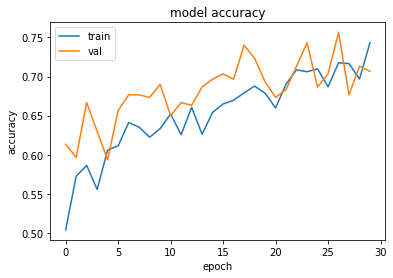

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
finetune_model.evaluate(validation_generator)

38/38 [==============================] - 38s 983ms/step - loss: 0.5771 - categorical_accuracy: 0.7467


[0.5771040916442871, 0.746666669845581]

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [29]:
predictions1 = finetune_model.predict(x=validation_generator, verbose=0)
cm = confusion_matrix(y_true=validation_generator.classes, y_pred=np.argmax(predictions1, axis=-1))

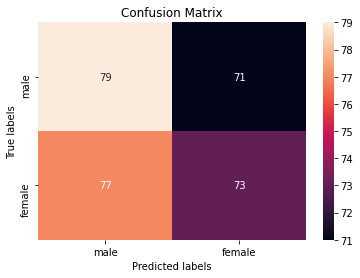

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
labels_ = ['male', 'female']
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels_); ax.yaxis.set_ticklabels(labels_);

In [31]:
finetune_model.save('mask_gender74_model.h5')

In [22]:
os.getcwd()

'/content/drive/My Drive/MASK'